# Proyecto 1

**Tema:** Predicción de enfermedades Cardíacas



|     Nombres      |      Apellidos       |     Login     |  Codigo   |
| :--------------: | :------------------: | :-----------: | :-------: |
|     Santiago     | Gonzalez Montealegre | s.gonzalez35  | 202012274 |
| Juliana Carolina |  Cardenas Barragan   | jc.cardenasb1 | 202011683 |


## Modelización

### Red Bayesiana

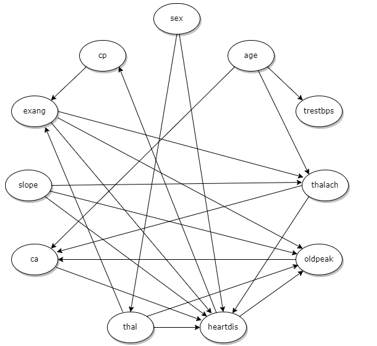

## Librerías Requeridas

In [2]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

## Carga de Datos

In [3]:
columnas = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

df = pd.read_csv("../Data/processed.cleveland.data", names=columnas)

df.age = df.age.astype(int)
df.sex = df.sex.astype(int)
df.cp = df.cp.astype(int)
df.trestbps = df.trestbps.astype(int)
df.chol = df.chol.astype(int)
df.fbs = df.fbs.astype(int)
df.restecg = df.restecg.astype(int)
df.thalach = df.thalach.astype(int)
df.exang = df.exang.astype(int)
df.slope = df.slope.astype(int)

# ------------
# Null values
# ------------

df['caNull'] = df['ca']
df.loc[df['caNull'] == '?', 'ca'] = float(df.ca.mode()[0])
df.loc[df['caNull'] != '?', 'ca'] = df['ca']
df['ca'] = pd.to_numeric(df['ca']).astype('int32')

df['thalNull'] = df['thal']
df.loc[df['thalNull'] == '?', 'thal'] = float(df.thal.mode()[0])
df.loc[df['thalNull'] != '?', 'thal'] = df['thal']
df['thal'] = pd.to_numeric(df['thal']).astype('int32')

# ------------
# Target
# ------------

df.loc[df['num'] == 0, 'heartdis'] = 0
df.loc[df['num'] != 0, 'heartdis'] = 1
df.heartdis = df.heartdis.astype(int)

# ------------
# Discretizacion
# ------------

#  Age

df['ageNum'] = df['age']

q1 = df['ageNum'].describe()['25%']
q2 = df['ageNum'].describe()['50%']
q3 = df['ageNum'].describe()['75%']

df.loc[df['ageNum'] < q1, 'age'] = 1
df.loc[(q1 <= df['ageNum']) & (df['ageNum'] < q2), 'age'] = 2
df.loc[(q2 <= df['ageNum']) & (df['ageNum'] < q3), 'age'] = 3
df.loc[(q3 <= df['ageNum']) & (df['ageNum'] < 80), 'age'] = 4

# Trestbps

df['trestbpsNum'] = df['trestbps']

mean = df['trestbps'].mean()

df.loc[df['trestbpsNum'] < mean, 'trestbps'] = 1
df.loc[(mean <= df['trestbpsNum']) & (df['trestbpsNum'] < 100000), 'trestbps'] = 2

# Chol

df['cholNum'] = df['chol']

mean = df['chol'].mean()

df.loc[df['cholNum'] < mean, 'chol'] = 1
df.loc[(mean <= df['cholNum']) & (df['cholNum'] < 100000), 'chol'] = 2

# Thalach

df['thalachNum'] = df['thalach']

q1 = df['thalachNum'].describe()['50%']

df.loc[df['thalachNum'] < q1, 'thalach'] = 1
df.loc[(q1 <= df['thalachNum']) & (df['thalachNum'] < 100000), 'thalach'] = 2

# Oldpeak

df['oldpeakNum'] = df['oldpeak']

df.loc[df['oldpeakNum'] < 0.5, 'oldpeak'] = 1
df.loc[(0.5 <= df['oldpeakNum']) & (df['oldpeakNum'] < 1), 'oldpeak'] = 2
df.loc[(1 <= df['oldpeakNum']) & (df['oldpeakNum'] < 1.5), 'oldpeak'] = 3
df.loc[(1.5 <= df['oldpeakNum']) & (df['oldpeakNum'] < 2), 'oldpeak'] = 4
df.loc[(2 <= df['oldpeakNum']) & (df['oldpeakNum'] < 10), 'oldpeak'] = 5

df.oldpeak = df.oldpeak.astype(int)

# ------------
# Drop columns
# ------------
df.drop(['num', 'caNull', 'thalNull', 'ageNum', 'trestbpsNum', 'cholNum', 'thalachNum', 'oldpeakNum'], axis=1, inplace=True)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heartdis
0,4,1,1,2,1,1,2,1,0,5,3,0,6,0
1,4,1,4,2,2,0,2,1,1,4,2,3,3,1
2,4,1,4,1,1,0,2,1,1,5,2,2,7,1
3,1,1,3,1,2,0,0,2,0,5,3,0,3,0
4,1,0,2,1,1,0,2,2,0,3,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1,1,1,1,2,0,0,1,0,3,2,0,7,1
299,4,1,4,2,1,1,0,1,0,5,2,2,7,1
300,3,1,4,1,1,0,0,1,1,3,2,1,7,1
301,3,0,2,1,1,0,2,2,0,1,2,1,3,1


## Creación Red

In [4]:
# Creacion del modelo del grafo
model = BayesianNetwork(
    [
        ('sex', 'thal'),
        ('sex', 'heartdis'),
        ('cp', 'exang'),
        ('exang', 'oldpeak'),
        ('exang', 'thalach'),
        ('slope', 'heartdis'),
        ('slope', 'oldpeak'),
        ('slope', 'thalach'),
        ('ca', 'heartdis'),
        ('thal', 'exang'),
        ('thal', 'heartdis'),
        ('thal', 'oldpeak'),
        ('heartdis', 'cp'),
        ('heartdis', 'oldpeak'),
        ('age', 'ca'),
        ('age', 'thalach'),
        ('age', 'trestbps'),
    ]
)

## Parametrización

### Máxima Verosimilitud

In [5]:
model.fit (
    data=df,
    estimator=MaximumLikelihoodEstimator
)
model.check_model()

True

In [6]:
for i in model.nodes():
    print(i)
    print(model.get_cpds(i))

sex
+--------+----------+
| sex(0) | 0.320132 |
+--------+----------+
| sex(1) | 0.679868 |
+--------+----------+
thal
+---------+----------------------+---------------------+
| sex     | sex(0)               | sex(1)              |
+---------+----------------------+---------------------+
| thal(3) | 0.8350515463917526   | 0.4223300970873786  |
+---------+----------------------+---------------------+
| thal(6) | 0.010309278350515464 | 0.0825242718446602  |
+---------+----------------------+---------------------+
| thal(7) | 0.15463917525773196  | 0.49514563106796117 |
+---------+----------------------+---------------------+
heartdis
+-------------+---------------------+-----+----------+----------+----------+
| ca          | ca(0)               | ... | ca(3)    | ca(3)    | ca(3)    |
+-------------+---------------------+-----+----------+----------+----------+
| sex         | sex(0)              | ... | sex(1)   | sex(1)   | sex(1)   |
+-------------+---------------------+-----+--------

## Inferencia

In [7]:
# ------------------------------
# Funciones para discretizar
# ------------------------------

def getAgeDiscrete(age):
    if age < 48:
        return 1
    elif age < 56:
        return 2
    elif age < 61:
        return 3
    else:
        return 4

def getTrestbpsDiscrete(trestbps):
    if trestbps < 131.689769:
        return 1
    else:
        return 2
    
def getCholDiscrete(chol):
    if chol < 246.693069:
        return 1
    else:
        return 2
    
def getThalachDiscrete(thalach):
    if thalach < 153:
        return 1
    else:
        return 2
    
def getOldpeakDiscrete(oldpeak):
    if oldpeak < 0.5:
        return 1
    elif oldpeak < 1:
        return 2
    elif oldpeak < 1.5:
        return 3
    elif oldpeak < 2:
        return 4
    else:
        return 5

In [36]:
def inferenceEvidence(evidence):
    infer = VariableElimination(model)

    prob = infer.query(variables=['heartdis'], evidence=evidence)
    
    return prob.values.tolist()

evidence = {
    'oldpeak': 5,
}
inferenceEvidence(evidence)

[0.23396420625434186, 0.7660357937456581]

In [9]:
matriz = {
    "Edad":{"0":199},
    "Sexo":{"0":""},
    "Presi\u00f3n arterial":{"0":140},
    "Frecuencia card\u00edaca m\u00e1xima":{"0":154},
    "Colesterol s\u00e9rico":{"0":245},
    "Az\u00facar en sangre en ayunas":{"0":""},
    "Tipo de dolor en el pecho":{"0":""},
    "Angina inducida por el ejercicio":{"0":""},
    "Resultados ECG en reposo":{"0":""},
    "Depresi\u00f3n del ST":{"0":100},
    "Pendiente del segmento ST":{"0":""},
    "Presencia de talasemia":{"0":""},
    "Vasos afectados":{"0":""}
    }

atributos = {
    'age': 'Edad',
    'sex': 'Sexo',
    'cp': 'Tipo de dolor en el pecho',
    'trestbps': 'Presi\u00f3n arterial',
    'chol': 'Colesterol s\u00e9rico',
    'fbs': 'Az\u00facar en sangre en ayunas',
    'restecg': 'Resultados ECG en reposo',
    'thalach': 'Frecuencia card\u00edaca m\u00e1xima',
    'exang': 'Angina inducida por el ejercicio',
    'oldpeak': 'Depresi\u00f3n del ST',
    'slope': 'Pendiente del segmento ST',
    'ca': 'Vasos afectados',
    'thal': 'Presencia de talasemia'
}

resultados = {}
for atributo in atributos:
    valor = atributos[atributo]
    resultados[atributo] = matriz[valor]['0']
    
evidence = {k: v for (k, v) in resultados.items() if type(v) != str}

for k, v in evidence.items():
    if k == 'age':
        age_discrete = getAgeDiscrete(v)
        evidence[k] = age_discrete
    if k == 'trestbps':
        trestbps_discrete = getTrestbpsDiscrete(v)
        evidence[k] = trestbps_discrete
    if k == 'chol':
        chol_discrete = getCholDiscrete(v)
        evidence[k] = chol_discrete
    if k == 'thalach':
        thalach_discrete = getThalachDiscrete(v)
        evidence[k] = thalach_discrete
    if k == 'oldpeak':
        oldpeak_discrete = getOldpeakDiscrete(v)
        evidence[k] = oldpeak_discrete

nodos = list(model.nodes())

evidence = {k: v for (k, v) in evidence.items() if k in nodos}
evidence

{'age': 4, 'trestbps': 2, 'thalach': 2, 'oldpeak': 5}

In [20]:
inferenceEvidence(evidence)

[0.47582334046718433, 0.5241766595328157]

In [13]:
import plotly.express as px

In [34]:
prob = inferenceEvidence(evidence)
df = pd.DataFrame({'label': ['No Tiene Enfermedad', 'Tiene Enfermedad'], 'prob': prob})
prob
df

,label,prob
0,No Tiene Enfermedad,0.475823
1,Tiene Enfermedad,0.524177


In [35]:
px.pie(df, names='label', values='prob', title='Probabilidad Enfermedad Cardíaca')